## 04 - Portfolio Performance
Using the `get_ticker_timeseries()` function defined in the previous chapter, I can retrieve the time series of my portfolio from the transactions DataFrame and calculate various performance metrics.

**Objective:**

In this notebook, I aim to compute the following portfolio **performance** metrics:
- Total Return, Annual Return, Annual Volatility, Sharpe Ratio;
- Drawdown periods and **maximum drawdown**;
- Portfolio **monthly revenue**.

$$\text{Portfolio Total Return} = \frac{\text{Portfolio Value }_{\text{end}}}{\text{Portfolio Value }_{\text{start}}} - 1$$
But because I BUY and SELL Shares of my assets over time and I may occasionally receive some cash Dividends, I cannot just use the `Market_Value` of the assets over time to evaluate my Portfolio **Total Return**. I need to consider that the `Market_Value` of the assets in my Portfolio may change over time after `Subscriptions` and `Redemptions`, not only after asset **Price** changes.

Therefore - similary to what discussed for single assets - a key consideration is: **Which portfolio indicator should I use to assess performance?**

I want to compare the Portfolio's `Market_Value` and/or `Income` to something that tells me if I'm earning or loosing money. To answer this, I revisit the table that separates **incomes** and **costs** in my portfolio:
| Incomes | Costs |
|---------------|------------------|
| (Current) Market_Value | Subscriptions |
| Redemptions | Commissions |
| Dividends | Taxes |

*Notes:*
- In the code I define `Costs` as the sum of **Commissions** + **Taxes** (i.e., transactional costs).
- `Income` is defined as: `Market_Value` + `Redemptions` + `Dividends`.

I analyze my **portfolio costs** over time in two ways:
- `Tot_Costs` = `Subscriptions` + `Costs` → the **cumulative** amount of capital invested at each point in time.
- `Net_Costs` = (`Subscriptions` + `Costs`) - (`Redemptions` + `Dividends`) → the **net capital** still invested over time.

These serve as the denominators to normalize my portfolio's value over time, providing a clearer picture of its performance:

$\text{Total Return Index} = \frac{\text{Income}}{\text{Total Costs}}$ → represents **Total Return** over time.

$\text{Active Investment Return Index} = \frac{\text{Market Value}}{\text{Net Costs}}$ → represents **Unrealized Return** on currently invested capital.

Finally, I define: **Profit/Loss = Income - Tot_Costs** = `Revenue`. Thus, the most recent value in the `Revenue` time series reflects the current profit or loss position of my portfolio.

In [1]:
# import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
plt.style.use('ggplot')

In [3]:
# importing the necessary functions from utils.py
from utils import load_transactions, get_ticker_timeseries

In [4]:
# Loading the Portfolio Transactions
excel_path = '../data/transactions_carlo.xlsx'
df_transacts = load_transactions(excel_path=excel_path, sheet_name=0)

#### A. Creating the Portfolio DataFrame

In [5]:
# Sampling one asset time series DataFrame
get_ticker_timeseries(transactions=df_transacts,ticker='CSSPX').tail(2)

,Shares,Price,Net_Costs,Tot_Costs,Income,Market_Value,Revenue
Date,,,,,,,
2025-05-15,84,561.750000,38173.08,38173.08,47187.00000,47187.00000,9013.92000
2025-05-16,84,566.109985,38173.08,38173.08,47553.23877,47553.23877,9380.15877


In [6]:
# Create a Dictionary with all asset data
assets = {}
for tick in df_transacts['Ticker'].unique():
    assets[tick] = get_ticker_timeseries(transactions=df_transacts,ticker=tick)

In [7]:
cols = ['Net_Costs','Tot_Costs','Income','Market_Value','Revenue']

# list of the DataFrames per each TICKER to concatenate
pf_list = []

for col in cols:
    sub_list = []
    for tick in df_transacts['Ticker'].unique():
        sub_list.append(assets[tick][col])
    # filling missing values with day before values and with 0s the days earlier than Ticker 1st BUY
    sub_df = pd.concat(sub_list,join='outer',axis=1).ffill().fillna(0)
    pf_list.append(sub_df.sum(axis=1))

In [8]:
portfolio = pd.concat(pf_list,axis=1)
portfolio.columns = cols
portfolio.head()

,Net_Costs,Tot_Costs,Income,Market_Value,Revenue
Date,,,,,
2023-02-15,100135.42,100135.42,100196.958725,100196.958725,61.538725
2023-02-16,100135.42,100135.42,100226.040298,100226.040298,90.620298
2023-02-17,100135.42,100135.42,99878.510498,99878.510498,-256.909502
2023-02-20,100135.42,100135.42,99861.369431,99861.369431,-274.050569
2023-02-21,100135.42,100135.42,99336.730286,99336.730286,-798.689714


In [9]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 569 entries, 2023-02-15 to 2025-05-16
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Net_Costs     569 non-null    float64
 1   Tot_Costs     569 non-null    float64
 2   Income        569 non-null    float64
 3   Market_Value  569 non-null    float64
 4   Revenue       569 non-null    float64
dtypes: float64(5)
memory usage: 26.7 KB


I can write a function to aggregate the individual time series of each asset into a unified portfolio-level time series. The function below builds this combined time series by summing key metrics—such as Net Costs, Total Costs, Income, Market Value, and Revenue—across all tickers. It handles missing data by forward-filling and filling initial gaps with zeros, ensuring a clean, continuous portfolio view over time.

*Note*. `ffill()` fills missing values with the day before data; missing values on days earlier than a Ticker first day appearance in the portfolio are filled with `0s`.

In [10]:
def build_portfolio_timeseries(transactions, get_ticker_timeseries):
    """
    Build the portfolio-level time series from individual asset time series.
    
    Parameters:
        transactions (pd.DataFrame): DataFrame containing transaction data with a 'Ticker' column.
        get_ticker_timeseries (function): Function to retrieve time series for a given ticker.
    
    Returns:
        pd.DataFrame: Combined portfolio time series with columns:
                      ['Net_Costs', 'Tot_Costs', 'Income', 'Market_Value', 'Revenue']
    """
    cols = ['Net_Costs', 'Tot_Costs', 'Income', 'Market_Value', 'Revenue']
    tickers = transactions['Ticker'].unique()

    # Step 1: Create a dictionary of time series per ticker
    assets = {}
    for tick in tickers:
        assets[tick] = get_ticker_timeseries(transactions=transactions, ticker=tick)

    # Step 2: Aggregate each metric across all tickers
    pf_list = []
    for col in cols:
        sub_list = [assets[tick][col] for tick in tickers]
        # ffill() fills missing values with day before data; 0s fill days earlier than Ticker 1st BUY
        sub_df = pd.concat(sub_list, join='outer', axis=1).ffill().fillna(0)
        pf_list.append(sub_df.sum(axis=1))

    # Step 3: Assemble the final portfolio DataFrame
    portfolio = pd.concat(pf_list, axis=1)
    portfolio.columns = cols

    return portfolio

In [11]:
portfolio_df = build_portfolio_timeseries(transactions=df_transacts, 
                                          get_ticker_timeseries=get_ticker_timeseries)
portfolio_df.head(3)

,Net_Costs,Tot_Costs,Income,Market_Value,Revenue
Date,,,,,
2023-02-15,100135.42,100135.42,100196.958725,100196.958725,61.538725
2023-02-16,100135.42,100135.42,100226.040298,100226.040298,90.620298
2023-02-17,100135.42,100135.42,99878.510498,99878.510498,-256.909502


For my live portfolio management, the **Active Investment Return Index** reflects how well my ongoing investments are performing relative to the risk I'm taking. AIRI shows the return on the **active part** of my portfolio, excluding withdrawn or realized gains.

I'm using the variable the variable `airi` for **Active Investment Return Index**.

<Axes: title={'center': 'Active Investment Return Index Over Time'}, xlabel='Date'>

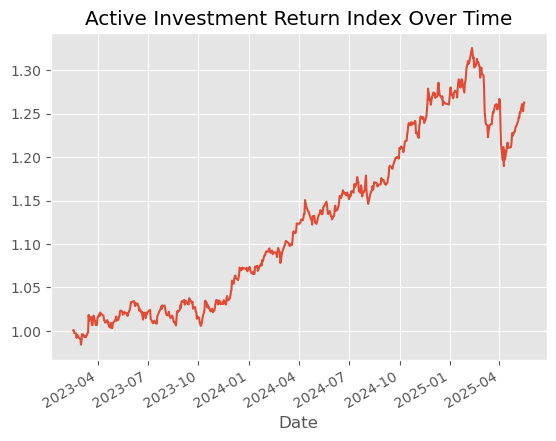

In [12]:
# Creating aire pd.Series from portfolio_df DataFrame
airi = portfolio_df.Market_Value/portfolio_df.Net_Costs
airi.name = 'AIRI'
airi.plot(title='Active Investment Return Index Over Time')

#### B. Calculating Total Return, Annual Return, Annual Volatility, Sharpe Ratio.

I use the **Total Return Index (TRI)** to calculate portfolio Total Return, Annualized Return, and Annualized Volatility. **TRI** shows how much my initial and subsequent investments have grown based on the income generated and the volatility of the income-based return.

I'm using the variable `tri` for **Total Return Index**.

<Axes: title={'center': 'Total Return Index Over Time'}, xlabel='Date'>

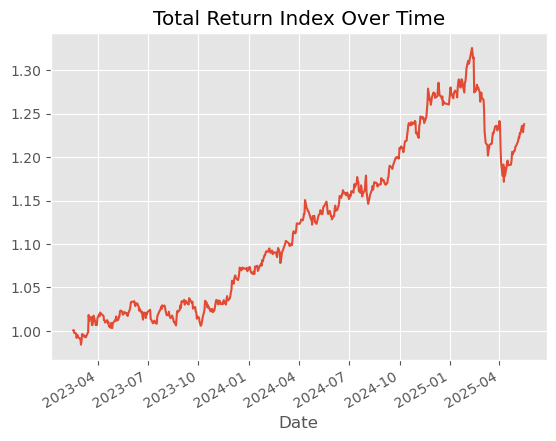

In [13]:
tri = portfolio_df.Income/portfolio_df.Tot_Costs
tri.name = 'TRI'
tri.plot(title='Total Return Index Over Time')

Based on what stated above, I take the most recent `tri` value as *proxy* of the $\text{Total Return}$: 

```python
tot_ret = tri.iloc[-1] - 1
```

Then I use the following formulas:

- $\text{Annualized Return} = (1 + \text{Total Return})^{\frac{1}{N}} -1$, where
    - $N$ is the number of years of the Portfolio Series;

- $\sigma_{\text{annualized}} = \sigma_{\text{measured}} \cdot \sqrt{T}$, where
    - $\sigma_{\text{annualized}}$ is the portfolio annualized standard deviation,
    - $\sigma_{\text{measured}}$ is the portfolio measured standard deviation,
    - $T$ is the number of data points per year (usually 252 trading days); 

- $\text{Sharpe Ratio} = \frac{\text{Annualized Return}}{\sigma_{\text{annualized}}}$.


In [14]:
# taking most recent aire value as Total Return
tot_ret = tri.iloc[-1] - 1
# calculate nr of years of the portfolio serie
pf_years = (tri.index[-1] - tri.index[0])/pd.to_timedelta('365.25D') # length in years
# calculate annualized return
ann_ret = ((1 + tot_ret)**(1/pf_years))-1 # calculate annual return
# Calculate annualized volatility
ann_vol = np.std(tri.pct_change().dropna())*np.sqrt(252)
# Calculate Sharpe Ratio
sharpe = ann_ret/ann_vol

print('Total Return:', round(tot_ret*100, 2), '\nAnnualized Return:', round(ann_ret*100, 2), 
      '\nAnnualized Volatility:', round(ann_vol*100, 2), '\nSharpe Ratio:', round(sharpe, 2))

print('As of latest market data:', tri.index[-1].strftime('%Y-%m-%d'))

Total Return: 23.78 
Annualized Return: 9.95 
Annualized Volatility: 7.39 
Sharpe Ratio: 1.35
As of latest market data: 2025-05-16


#### C. Visualizing Portfolio Metrics over time.
- Plotting Portfolio Market Value vs Net Capital Invested
- Define two helper functions to avoid repeating code for plotting all metrics

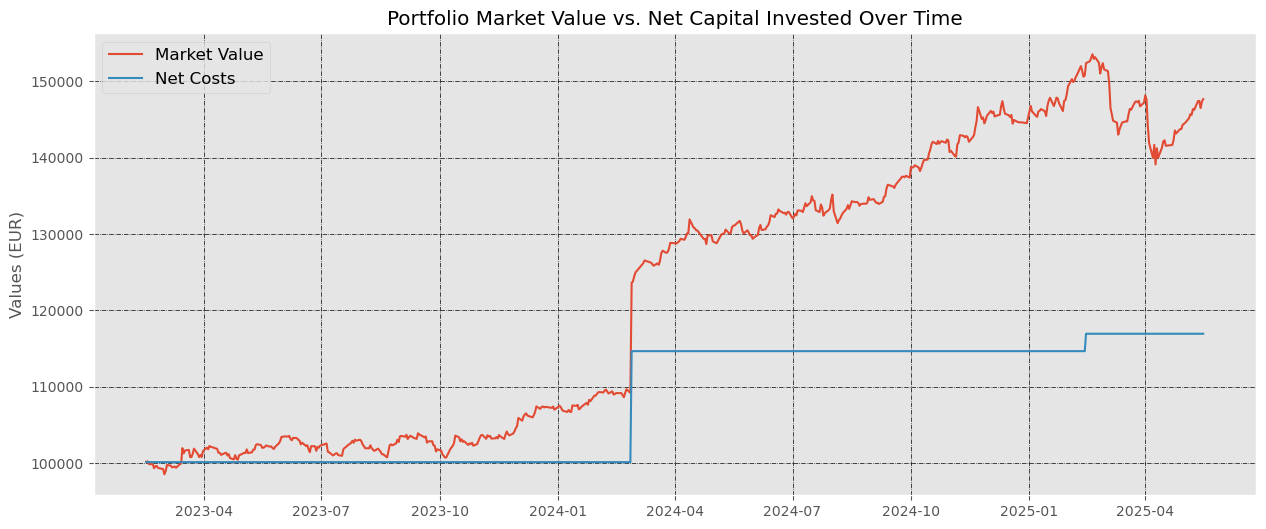

As of latest market data: 2025-05-16


In [15]:
# visualize Portfolio Market Value and Amount invested (Costs) Over Time
plt.figure(figsize=(15, 6))
_= plt.plot(portfolio_df.Market_Value, label = 'Market Value')
_= plt.plot(portfolio_df.Net_Costs, label = 'Net Costs')
_= plt.legend(loc='upper left', fontsize=12)
_= plt.ylabel('Values (EUR)')
_= plt.title('Portfolio Market Value vs. Net Capital Invested Over Time')
_= plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
# Save the plot as a PNG file
#plt.savefig("../images/pf_value_overtime.png", dpi=300)

plt.show()

print('As of latest market data:', portfolio_df.index[-1].strftime('%Y-%m-%d'))

Before visualizing other portfolio time series metrics, I define the `plot_timeseries()` function to visualize time series data. This function is designed to create clear and informative line plots of pandas Series or DataFrames, inheriting a consistent visual style applied at the beginning of a notebook.

Key features include:

-   **Handles Series and DataFrames:** Accepts both single time series (pandas Series) and multiple time series (columns of a pandas DataFrame).
-   **Consistent Default Styling:** Once called the a`apply_plot_config()` function, this notebook applies a predefined visual style (colors, line styles, grid, etc.). All subsequent plots generated using `plot_timeseries()` will inherit this style. The default style will be configured in the `utils.py` module.
-   **Customizable Appearance:** Offers arguments for setting the plot `title`, `ylabel`, `xlabel`, `legend location` (`legend_loc`), and explicitly controlling the `grid` display (overriding the default if needed within the function call).
-   **Flexible Styling:** Supports additional styling through keyword arguments (`**kwargs`) that are passed directly to `matplotlib.pyplot.plot()` for further customization. For DataFrames, I can apply uniform styling to all columns or use the `column_styles` argument for specific styling per column.

In [16]:
# Default plot configuration
PLOT_CONFIG = {
    'figure.figsize': (12, 6),
    'axes.titlesize': 16,
    'axes.labelsize': 12,
    'lines.linewidth': 1.5,
    'lines.linestyle': '-',
    'grid.linestyle': '--',
    'grid.alpha': 0.7,
    'grid.color': 'gray',
    'legend.fontsize': 10,
    'font.family': 'serif',  # Or 'sans-serif', etc.
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'savefig.dpi': 300,
    'axes.grid': True
}

def apply_plot_config():
    """Applies the default plot configuration to matplotlib."""
    plt.rcParams.update(PLOT_CONFIG)

In [17]:
def plot_timeseries(time_series_data, columns_to_plot=None,
                    title=None, ylabel=None, xlabel=None,
                    legend_loc='best', grid=None, column_styles=None,
                    figsize=None, **kwargs):
    """
    Plots one or more time series with consistent styling and optional
    figure size override.

    Parameters
    ----------
    time_series_data : pd.Series or pd.DataFrame
        The time series data to plot. If a DataFrame, specify `columns_to_plot`.
        The index should be a datetime object.
    columns_to_plot : list of str, optional
        List of column names to plot if `time_series_data` is a DataFrame.
        If None and `time_series_data` is a DataFrame, all columns will be plotted.
    title : str, optional
        The title of the plot.
    ylabel : str, optional
        The label for the y-axis.
    xlabel : str, optional
        The label for the x-axis.
    legend_loc : str, optional
        The location of the legend (e.g., 'best', 'upper left', 'lower right').
        Defaults to 'best'.
    grid : bool, optional
        Whether to display a grid on the plot. Defaults to True (or the value in PLOT_CONFIG if None).
    column_styles : dict, optional
        A dictionary where keys are column names (str) and values are dictionaries
        of keyword arguments to pass to `matplotlib.pyplot.plot()` for that
        specific column (e.g., {'Drawdown': {'color': 'red', 'linestyle': '-'}}).
        Defaults to None (uniform styling via `**kwargs`).
    figsize : tuple, optional
        Width and height of the figure in inches (e.g., (15, 8)).
        If None, the default from PLOT_CONFIG is used. Defaults to None.
    **kwargs :
        Additional keyword arguments passed to `matplotlib.pyplot.plot()`. These
        will be applied to all plotted lines unless overridden by `column_styles`.

    Returns
    -------
    None
        Displays the plot.
    """
    apply_plot_config()  # Apply the default configuration

    fig_size = figsize if figsize is not None else PLOT_CONFIG['figure.figsize']
    plt.figure(figsize=fig_size) # Ensure figure size is from config or customized

    if isinstance(time_series_data, pd.Series):
        plt.plot(time_series_data, label=time_series_data.name, **kwargs)
        plt.legend(loc=legend_loc, fontsize=PLOT_CONFIG['legend.fontsize'])
    elif isinstance(time_series_data, pd.DataFrame):
        if columns_to_plot is None:
            columns_to_plot = time_series_data.columns

        if column_styles is None:
            column_styles = {}

        for column in columns_to_plot:
            style = column_styles.get(column, {})
            all_styles = {**kwargs, **style}
            plt.plot(time_series_data.index, time_series_data[column], label=column, **all_styles)
        plt.legend(loc=legend_loc, fontsize=PLOT_CONFIG['legend.fontsize'])
    else:
        raise TypeError("time_series_data must be a pandas Series or DataFrame.")

    if title:
        plt.title(title, fontsize=PLOT_CONFIG['axes.titlesize'])
    if ylabel:
        plt.ylabel(ylabel, fontsize=PLOT_CONFIG['axes.labelsize'])
    if xlabel:
        plt.xlabel(xlabel, fontsize=PLOT_CONFIG['axes.labelsize'])
    if grid is None:
        plt.grid(PLOT_CONFIG['axes.grid'], linestyle=PLOT_CONFIG['grid.linestyle'],
                 alpha=PLOT_CONFIG['grid.alpha'], color=PLOT_CONFIG['grid.color'])
    elif grid is True:
        plt.grid(True, linestyle=PLOT_CONFIG['grid.linestyle'],
                 alpha=PLOT_CONFIG['grid.alpha'], color=PLOT_CONFIG['grid.color'])
    elif grid is False:
        plt.grid(False)

    plt.tight_layout()
    plt.show()

Plotting Portfolio **Income** vs. **cumulative** amount of capital invested Over Time:

In [18]:
portfolio_df.head()

,Net_Costs,Tot_Costs,Income,Market_Value,Revenue
Date,,,,,
2023-02-15,100135.42,100135.42,100196.958725,100196.958725,61.538725
2023-02-16,100135.42,100135.42,100226.040298,100226.040298,90.620298
2023-02-17,100135.42,100135.42,99878.510498,99878.510498,-256.909502
2023-02-20,100135.42,100135.42,99861.369431,99861.369431,-274.050569
2023-02-21,100135.42,100135.42,99336.730286,99336.730286,-798.689714


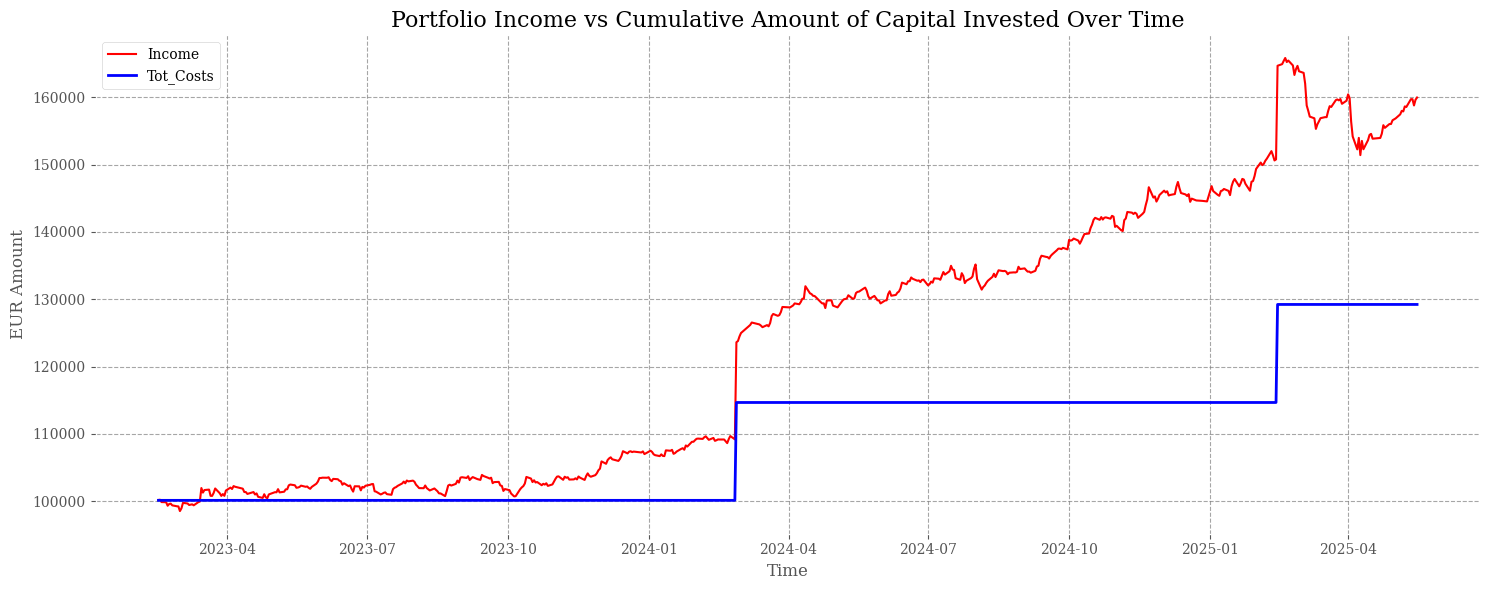

In [19]:
# Example usage of the function to visualize Portfolio Income vs. Tot_Costs 
plot_timeseries(
    time_series_data=portfolio_df,
    columns_to_plot=['Income', 'Tot_Costs'],
    title='Portfolio Income vs Cumulative Amount of Capital Invested Over Time',
    ylabel='EUR Amount',
    xlabel='Time',
    legend_loc='upper left',
    figsize=(15,6), # bigger figsize vs default (12,6)
    column_styles={
        'Income': {'color': 'red'},
        'Tot_Costs': {'color': 'blue','linewidth': 2}
    }
)

Plotting Portfolio P/L Over Time **Revenue = Income - Total Costs**:

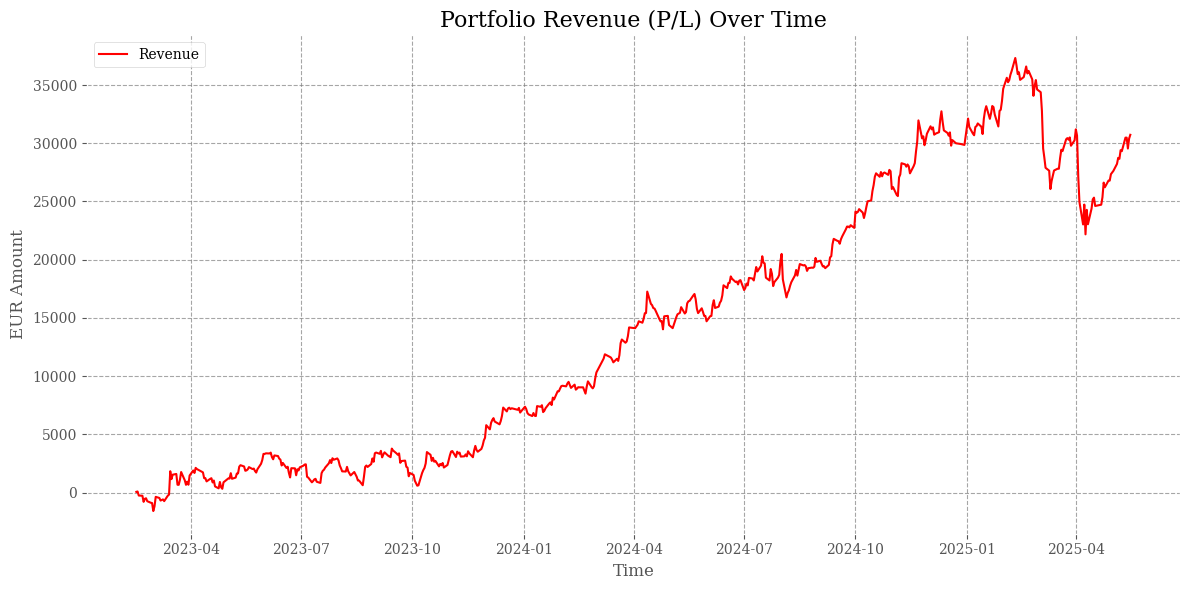

In [20]:
# Example usage to visualize Portfolio Revenue (P/L) = (Income) - (Tot_Costs)
plot_timeseries(
    time_series_data=portfolio_df.Revenue,
    title='Portfolio Revenue (P/L) Over Time',
    ylabel='EUR Amount',
    xlabel='Time',
    legend_loc='upper left',
    grid=True,
    color='red',
    linewidth=1.5
)

In [21]:
max_profits = round(portfolio_df.Revenue.max(),2)
date_max_profits = portfolio_df.Revenue.idxmax().strftime('%Y-%m-%d')
print('All time highest Portfolio Profits: ', max_profits)
print('Date of highest Portfolio Profits: ', date_max_profits)
print('Current Portfolio Profits: ', round(portfolio_df.Revenue.iloc[-1],2))
print('As of latest market data:', portfolio_df.Revenue.index[-1].strftime('%Y-%m-%d'))

All time highest Portfolio Profits:  37322.05
Date of highest Portfolio Profits:  2025-02-10
Current Portfolio Profits:  30724.4
As of latest market data: 2025-05-16


Plotting Portfolio **Total Return Index** Over Time:

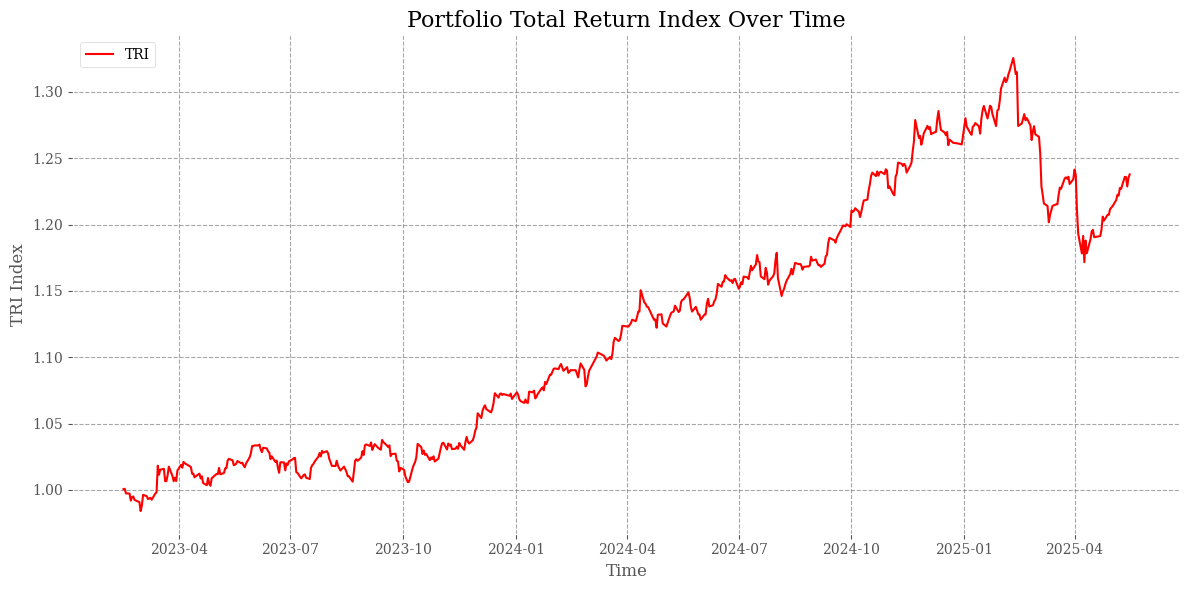

In [22]:
# Example usage to visualize TRI
plot_timeseries(
    time_series_data=tri,
    title='Portfolio Total Return Index Over Time',
    ylabel='TRI Index',
    xlabel='Time',
    legend_loc='upper left',
    grid=True,
    color='red',
    linewidth=1.5
)

Calculating and plotting *Drawdowns* and **Max Drawdown**. 

The **Active Investment Return Index** reflects how well my ongoing investments are performing relative to the risk I'm taking. Therefore I calculate *drawdowns* using the AIRI time series, that shows the return on the **active part** of my portfolio (money left invested).

In [23]:
# Calculating the rolling max of Portfolio Normalized Values using .rolling().max() over a 250 days window
roll_max = (airi).rolling(min_periods=1, window=250).max()

# Calculating the daily draw-down from rolling max
daily_drawdown = (airi)/roll_max - 1

# Calculating the rollling max daily draw-down over a 250 days window
max_daily_drawdown = daily_drawdown.rolling(min_periods=1, window=250).min()

# Creating the dataframe to visualize
df_drawdown = pd.DataFrame({
    'Drawdown': daily_drawdown,
    'Max_drawdown': max_daily_drawdown})

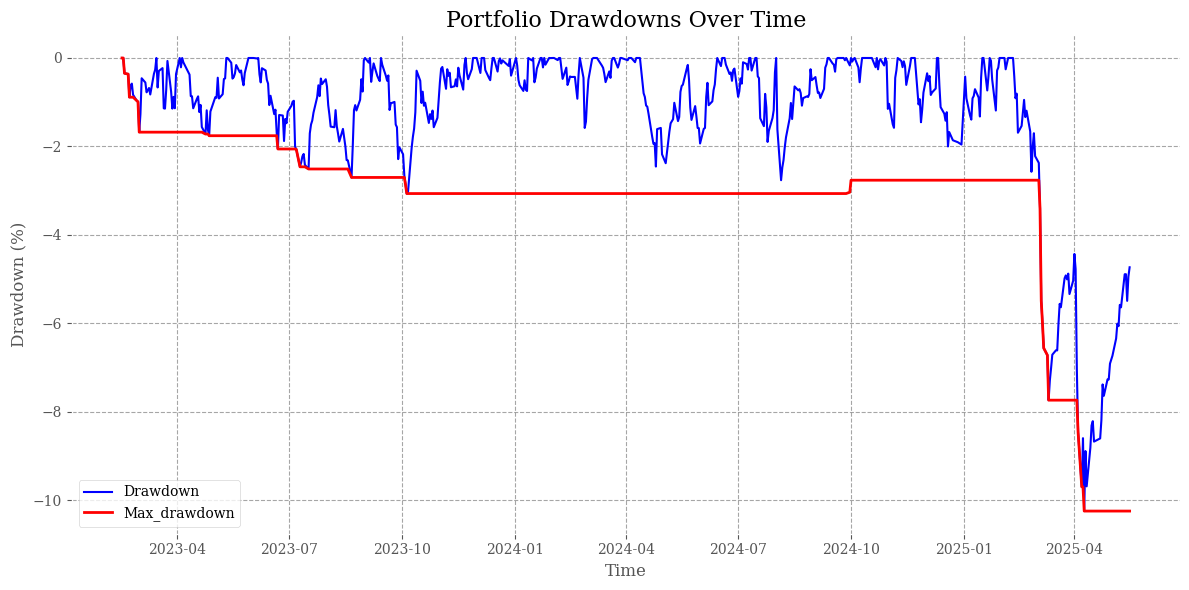

Max drawdown:  -10.25 %
Date of Max drawdown:  2025-04-09


In [24]:
# Using plot_timeseries() function to visualize drawdowns
plot_timeseries(
    time_series_data=df_drawdown*100,
    columns_to_plot=['Drawdown', 'Max_drawdown'],
    title='Portfolio Drawdowns Over Time',
    ylabel='Drawdown (%)',
    xlabel='Time',
    legend_loc='lower left',
    column_styles={
        'Drawdown': {'color': 'blue'},
        'Max_drawdown': {'color': 'red','linewidth': 2}}
    )

print("Max drawdown: ", round(df_drawdown.Drawdown.min()*100,2), "%")
print('Date of Max drawdown: ', df_drawdown.Drawdown.idxmin().strftime('%Y-%m-%d'))

I use the function `drawdown_metrics()` from `utils.py` that I defined in one of my other projects to create a table with the Portfolio 5 Highest Drawdowns.

In [25]:
from utils import drawdown_metrics

In [26]:
drawdowns = drawdown_metrics(asset_values_ts=airi)

drawdowns['duration'] = drawdowns['valley'] - drawdowns['start']
drawdowns['recovery_time'] = drawdowns['end'] - drawdowns['valley']
drawdowns['total_lenght'] = drawdowns['end'] - drawdowns['start']

print('5 Highest Drawdowns:\n')
drawdowns.head()

5 Highest Drawdowns:



,drawdown,start,valley,end,duration,recovery_time,total_lenght
0,-0.102500,2025-02-11,2025-04-09,NaT,57 days,NaT,NaT
1,-0.030668,2023-09-15,2023-10-05,2023-11-22,20 days,48 days,68 days
2,-0.027647,2024-08-02,2024-08-05,2024-09-12,3 days,38 days,41 days
3,-0.027025,2023-06-07,2023-08-21,2023-09-01,75 days,11 days,86 days
4,-0.024561,2024-04-15,2024-04-25,2024-06-14,10 days,50 days,60 days


Visualizing **Portfolio Monthly Revenues**

In [27]:
# taking the portfolio revenue time series
revenue = portfolio_df.Revenue

# Resample to get the revenue at the end of each month
end_of_month_revenue = revenue.resample('M').last()

# Get the first month's end revenue and take it as the first month's performance
first_month_performance = end_of_month_revenue.iloc[0]

# Calculate the performance for the rest of the months
subsequent_month_performance = end_of_month_revenue.diff()

# Manually set the first month's performance in the 'diff' result
subsequent_month_performance.iloc[0] = first_month_performance

In [28]:
# check that total revenue and sum of monthly revenue are equal
subsequent_month_performance.sum() == revenue.iloc[-1]

True

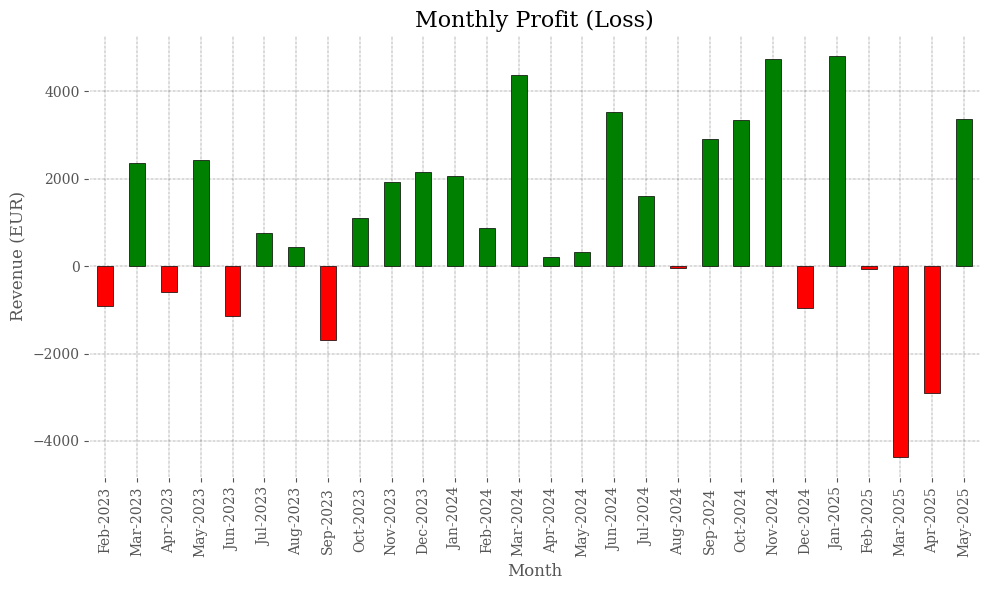

Total Current Portfolio Revenue:  30724.4
As of latest market data: 2025-05-16


In [29]:
# Visualizing 'subsequent_month_performance' (our pandas series with monthly performance)

# Create a color list where green is for positive values and red is for negative values
colors = ['green' if val > 0 else 'red' for val in subsequent_month_performance]

# Create the plot
plt.figure(figsize=(10, 6))
ax = subsequent_month_performance.plot(kind='bar', color=colors, edgecolor='black')

# Set the ticks to be in the middle of each bar
ax.set_xticks(range(len(subsequent_month_performance)))

# Format the x-tick labels to display month-year and center them under each bar
ax.set_xticklabels([x.strftime('%b-%Y') for x in subsequent_month_performance.index], rotation=90, ha='center')

# Add titles and labels
plt.title('Monthly Profit (Loss)')
plt.xlabel('Month')
plt.ylabel('Revenue (EUR)')
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.3)

# Adjust the layout to avoid label overlap
plt.tight_layout()
plt.show()

print('Total Current Portfolio Revenue: ', round(subsequent_month_performance.sum(), 2))
print('As of latest market data:', revenue.index[-1].strftime('%Y-%m-%d'))

I define the function `monthly_profit_loss()` so I can reuse it later for full portfolio view at the end of the project.

In [30]:
def monthly_profit_loss(portfolio_revenue_ts, plot=True):
    """
    Calculate and optionally visualize monthly profit/loss from a portfolio revenue time series.

    Parameters:
    -----------
    portfolio_revenue_ts : pd.DataFrame
        Portfolio or single Asset DataFrame containing a 'Revenue' column with a datetime index.

    plot : bool, default=True
        If True, display a bar plot of monthly P/L.

    Returns:
    --------
    pd.Series
        Series of monthly profit/loss values.
    """
    revenue = portfolio_revenue_ts['Revenue']

    # Resample to get the revenue at the end of each month
    end_of_month_revenue = revenue.resample('M').last()

    # Get the first month's end revenue
    first_month_performance = end_of_month_revenue.iloc[0]

    # Calculate monthly performance
    monthly_pl = end_of_month_revenue.diff()
    monthly_pl.iloc[0] = first_month_performance  # Set first month manually

    if plot:
        # Color bars by sign
        colors = ['green' if val > 0 else 'red' for val in monthly_pl]

        # Create the plot
        plt.figure(figsize=(10, 6))
        ax = monthly_pl.plot(kind='bar', color=colors, edgecolor='black')

        ax.set_xticks(range(len(monthly_pl)))
        ax.set_xticklabels(
            [x.strftime('%b-%Y') for x in monthly_pl.index],
            rotation=90, ha='center'
        )

        plt.title('Monthly Profit (Loss)')
        plt.xlabel('Month')
        plt.ylabel('Revenue (EUR)')
        plt.grid(which="major", color='k', linestyle='-.', linewidth=0.3)
        plt.tight_layout()
        plt.show()

        print('Total Current Portfolio Revenue:', round(monthly_pl.sum(), 2))
        print('As of latest market data:', revenue.index[-1].strftime('%Y-%m-%d'))

    return monthly_pl

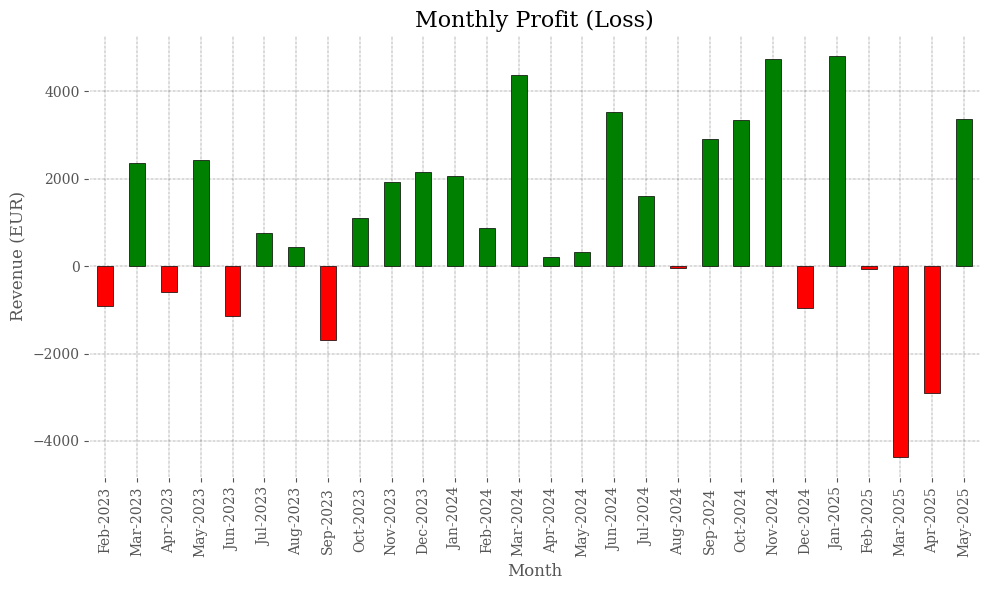

Total Current Portfolio Revenue: 30724.4
As of latest market data: 2025-05-16


In [31]:
# Example usage of the function
monthly_pl = monthly_profit_loss(portfolio_revenue_ts=portfolio_df, plot=True)

### Summary.
In this notebook, I defined the **Total Return Index (TRI)** and the **Active Investment Return Index (AIRI)**, which were used to:
- Calculate portfolio performance metrics such as Total Return, Annualized Return, Annualized Volatility, and Sharpe Ratio;
- Visualize several portfolio metrics over time, including drawdown periods, maximum drawdown, and monthly profit/loss (P/L).

To support a reusable and modular workflow, I also defined a few functions for comprehensive portfolio analysis:
- `build_portfolio_timeseries()` builds the portfolio-level time series from transaction data.
- `plot_timeseries()` and `apply_plot_config()` visualize time series and allow for customized plot titles and axis labels with consistent default styling.
- `monthly_profit_loss()` calculates and optionally visualizes monthly portfolio P/L.

Finally, I used the function `drawdown_metrics()` from `utils.py` to generate a table of the portfolio’s five largest drawdowns.